#Predicting the Interest Rate in New York State

#Setup

In [1]:
# Pandas
import pandas as pd


# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

#Scikit-learn for implemeting LinearRegression from a existing algorithm.
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import warnings
warnings.filterwarnings('ignore')

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

import time

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL
logging.getLogger('tensorflow').setLevel(logging.FATAL)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


# Loading and Preprocessing and Exploring the data
##Logical Definitions of Categories

**derived_dwelling_category**

This is an alphanumeric value that represents the derived dwelling type from Construction Method and Total Units fields for easier querying of specific records. 
Values:

Single Family (1-4 Units): Site-Built

Multifamily: Site-Built

Single Family (1-4 Units): Manufactured

Multifamily: Manufactured

**derived_race**

This is an alphanumeric value that represents the single aggregated race categorization derived from applicant/borrower and co-applicant/co-borrower race fields.
Values:

-American Indian or Alaska Native

-Asian

-Black or African American

-Native Hawaiian or Other Pacific Islander

-White

-2 or more minority races

-Joint

-Free Form Text Only

-Race Not Available


**derived_sex**

This is an alphanumeric value that represents the single aggregated sex categorization derived from applicant/borrower and co-applicant/co-borrower sex fields.

Values:

-Male

-Female

-Joint

-Sex Not Available
 
**business_or_commercial_purpose**

This is a numeric value that represents whether the covered loan or application is primarily for a business or commercial purpose
Values:

1 - Primarily for a business or commercial purpose

2 - Not primarily for a business or commercial purpose

1111 - Exempt


**loan_amount**

This is a numeric value that represents the amount of the covered loan, or the amount applied for.

**loan_to_value_ratio**

This is a numeric value that  represents the ratio of the total amount of debt secured by the property to the value of the property relied on in making the credit decision.

**interest_rate**

This is a numeric value that  represents the interest rate for the covered loan or application.

**rate_spread**

This is a numeric value that  represents the difference between the covered loan’s annual percentage rate (APR) and the average prime offer rate (APOR) for a comparable transaction as of the date the interest rate is set

**loan_term**

This is a numeric value that  represents the number of months after which the legal obligation will mature or terminate, or would have matured or terminated.

**property_value**

This is a numeric value that represents the value of the property securing the covered loan or, in the case of an application, proposed to secure the covered loan, relied on in making the credit decision. The values are rounded to the midpoint of the nearest $10,000 interval for which the reported value falls.

**occupancy_type**

This is a numeric value that represents the occupancy type for the dwelling.
Values:

1 - Principal residence

2 - Second residence

3 - Investment property

**total_units**

This is a numeric value that represents the number of individual dwelling units related to the property securing the covered loan or, in the case of an application, proposed to secure the covered loan
Values:

1

2

3

4

5-24

25-49

50-99

100-149

>149


**income**

This is a numeric value that represents the  gross annual income, in thousands of dollars, relied on in making the credit decision, or if a credit decision was not made, the gross annual income relied on in processing the application



**debt_to_income_ratio**

This is a numeric value that represents the ratio, as a percentage, of the applicant’s or borrower’s total monthly debt to the total monthly income relied on in making the credit decision.
Varying values; Ratios binned are:

<20%

20%-<30%

30%-<36%

37%

38%

39%

40%

41%

42%

43%

44%

45%

46%

47%

48%

49%

50%-60%

>60%

NA

Exempt


In [2]:
# Dataset link
# Format goes !wget -O <new file name> <download link>
!wget -O "dataset.csv" "https://ffiec.cfpb.gov/v2/data-browser-api/view/csv?years=2021&states=NY&actions_taken=1&loan_types=1"

pulled_df=pd.read_csv('dataset.csv')


--2023-05-11 00:37:45--  https://ffiec.cfpb.gov/v2/data-browser-api/view/csv?years=2021&states=NY&actions_taken=1&loan_types=1
Resolving ffiec.cfpb.gov (ffiec.cfpb.gov)... 54.144.33.120, 52.45.47.118
Connecting to ffiec.cfpb.gov (ffiec.cfpb.gov)|54.144.33.120|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cfpb-hmda-public.s3.amazonaws.com/prod/data-browser/2021/filtered-queries/snapshot/319efb74d6591ae47f238c8304c64317.csv [following]
--2023-05-11 00:37:45--  https://cfpb-hmda-public.s3.amazonaws.com/prod/data-browser/2021/filtered-queries/snapshot/319efb74d6591ae47f238c8304c64317.csv
Resolving cfpb-hmda-public.s3.amazonaws.com (cfpb-hmda-public.s3.amazonaws.com)... 52.217.226.185, 3.5.8.15, 52.217.132.241, ...
Connecting to cfpb-hmda-public.s3.amazonaws.com (cfpb-hmda-public.s3.amazonaws.com)|52.217.226.185|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170347957 (162M) [text/csv]
Saving to: ‘dataset.csv’



In [3]:
# Let's clean/ transform the data
# This link is necessary to understand the structure of the data: https://ffiec.cfpb.gov/documentation/2021/derived-data-fields/
# Steps
# (1) Think about which columns are relevant to our analysis; drop all other columns
# (2) Drop rows that contain invalid values
# (3) Transform the data (add indicator variables)

# (1) -- Rows that we care about: [derived_dwelling_category, derived_race,
# derived_sex, business_or_commercial_purpose, loan_amount, loan_to_value_ratio,
# interest_rate, rate_spread, loan_term,property_value, occupancy_type,
# total_units, income, debt_to_income_ratio]

# First, the columns we are going to use
cleaned_df_1 = pulled_df[['derived_dwelling_category', 'derived_race',
                     'derived_sex',
                     'business_or_commercial_purpose', 'loan_amount',
                     'loan_to_value_ratio', 'interest_rate', 'rate_spread',
                     'loan_term', 'property_value', 'occupancy_type',
                     'total_units', 'income', 'debt_to_income_ratio']]

# (2) -- Drop rows containing invalid values
cleaned_df_2 = cleaned_df_1.dropna()
cleaned_df_2 = cleaned_df_2[cleaned_df_2['derived_race']
                            .isin(['Asian', 'White',
                                   'Black or African American'])]
cleaned_df_2 = cleaned_df_2[cleaned_df_2['derived_sex']
                            .isin(['Male', 'Joint', 'Female'])]
cleaned_df_2 = cleaned_df_2[cleaned_df_2['business_or_commercial_purpose']
                            .isin([1, 2])]                           

cleaned_df_2 = cleaned_df_2[cleaned_df_2['loan_term'] != '1']
cleaned_df_2 = cleaned_df_2[cleaned_df_2['loan_term'] != '2']
cleaned_df_2 = cleaned_df_2[cleaned_df_2['debt_to_income_ratio']
                            .isin(['36', '37', '38', '39', '40', '41', '42',
                                   '43', '44', '45', '46', '47', '48', '49'])] 

for col_name in cleaned_df_2.columns:
  cleaned_df_2 = cleaned_df_2[cleaned_df_2[col_name] != 'NA']

# (3) -- Transformations on the data, creating dummy (indicator) variables or
# converting the columns that should be numbers into their numeric values

# Note that 'total_units colum' is usually categorical
categorical_columns = ['derived_dwelling_category', 'derived_race',
                       'derived_sex','business_or_commercial_purpose',
                       'occupancy_type']

# numerical_columns = ['loan_amount', 'loan_to_value_ratio', 'interest_rate',
#                      'rate_spread', 'loan_term', 'property_value',
#                      'total_units', 'income', 'debt_to_income_ratio']

cleaned_df_3 = pd.get_dummies(cleaned_df_2, columns=categorical_columns)
for column_name in cleaned_df_3.columns:
  cleaned_df_3[column_name] = pd.to_numeric(cleaned_df_3[column_name])

df = cleaned_df_3


## The idea behind what we are doing
We want to take into consideration a borrower's information, and then choose what interest rate to charge that borrower.

The variables are as follows:
*   loan_to_value_ratio: ratio of amount borrowed versus value of the property
*   interest_rate: the baseline interest rate of a typical loan at the time
*   loan_term: the length of the loan (in months)
*   total_units: an indicator variable indicating how many housing units are in the property of interest (in ranges)
*   debt_to_income_ratio: ratio of amount borrowed versus income of the borrower
*   derived_dwelling_category: indicator variable discussing type of house
*   derived_race: indicator variable of race (Asian, White, or Black); reference group in our regression is White
*   derived_sex: indicator variable of sex (male, female, or joint); reference group in our regression is male
*   business_or_commercial_purpose: indicator variable indicating if the mortgage is for a business purpose or not
*   occupancy_type: indicator variable of what type of residence the property is for (principal residence, secondary residence, or investment property)
*   rate_spread: the difference between a this loan's interest rate, and the risk-free rate at the time of issuance

We are looking to predict the rate_spread variable with these other variables. With a theoretically perfect model, we would use our model, instead, to use a borrower's characteristics to charge them a specific interest rate. The rate we would charge them is equal to interest_rate + rate_spread.


We first work using a really simple statistical model for our regression, looking at the statsmodel for greater transparency as to if our variables do possess an impact on rate_spread. Below is what our regression equation looks like.

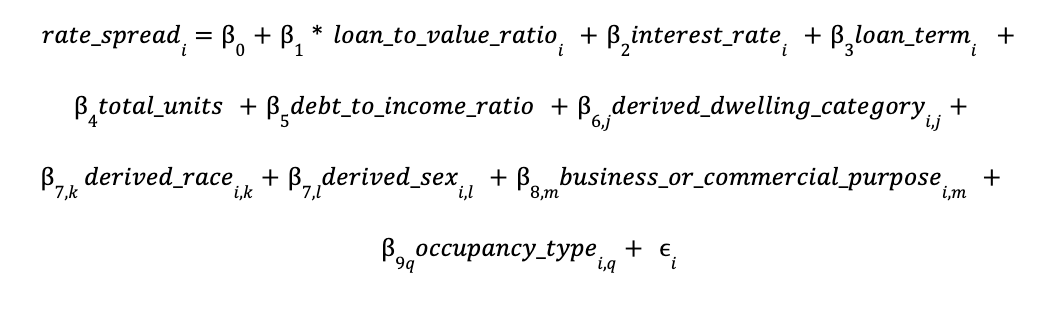

The model is classified as a continuous machine learning problem, specifically Linear Regression. Linear Regression is a supervised learning technique that involves learning the relationship between the features and the target. The target values are continuous, which means that the values can take any values between an interval. 



In [4]:
# We look at this basic model to see what a baseline level of performance looks
# like, and a standard R^2 level that we want to beat

# We use statsmodels for this model as it shows easy-to-understand OLS
# Regression Results that we can interpret the coefficients of

import statsmodels.api as sm
#define response variable
y = df['rate_spread']

x_vars = list(df.columns.values)
x_vars.remove('rate_spread') # This is the dependent variable

# Get rid of dummy variables for an econometric regression (to compare
# coefficients against a reference group)
x_vars.remove('derived_dwelling_category_Single Family (1-4 Units):Manufactured')
x_vars.remove('derived_race_White')
x_vars.remove('derived_sex_Male')
x_vars.remove('business_or_commercial_purpose_1')
x_vars.remove('occupancy_type_1')

#define predictor variables
X = df[x_vars]

#add constant to predictor variables
X = sm.add_constant(X)

#fit linear regression model
model = sm.OLS(y, X).fit()

#view model summary
print(model.summary().as_text())



                            OLS Regression Results                            
Dep. Variable:            rate_spread   R-squared:                       0.797
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                 3.513e+04
Date:                Thu, 11 May 2023   Prob (F-statistic):               0.00
Time:                        00:38:14   Log-Likelihood:                -38012.
No. Observations:              143232   AIC:                         7.606e+04
Df Residuals:                  143215   BIC:                         7.623e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                                                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------

#Training the Model
The problem was modeled using a multivariate linear regression and it was trained using a cost function MSE and evaluated using $R^2$ .  Training a model simply means learning (determining) good values for all the weights and the bias from labeled examples.It is setting its parameters so that the model best fits the training set. For this purpose, it was required to get a measure of how well (or poorly) the model fits the training data. 

Using MSE as a performance measure of a regression model means to find the value of θ that minimizes the MSE, in order to train  the model. Since loss is the penalty for a bad prediction,  if the model's prediction is perfect, the loss is zero; otherwise, the loss is greater. The goal of training a model is to find a set of weights and biases that have low loss, on average, across all examples.

The model was implemented using a polynomial of degree 3 because we wanted a better performance. This would help reduce some inherent bias. This was one way to make the model more complex.  A higher degree would overfit the model.  This allows the model to see if there is any non- linear relationships between the target variable.




In [5]:
# Linear regression model

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score

# Choose a seed for reproducibility
np.random.seed(42)

# Separate the input features (X) and the target variable (y)
X = df.drop('rate_spread', axis=1)
y = df['rate_spread']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Create a scikit-learn pipeline
pipeline = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(degree=3),
    LinearRegression()
)

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = pipeline.predict(X_test)

#Evaluating the model

Evaluation metrics are used to measure the quality of the statistical or machine learning model.  Mean Squared Error (MSE). The most common metric for regression tasks is MSE. It has a convex shape. It is the average of the squared difference between the predicted and actual value. Since it is differentiable and has a convex shape, it is easier to optimize.

$$ MSE = \frac{1}{m}\sum_{i=1}^m\left( h_{\theta}(x^{(i)}) - y^{(i)}\right)^2$$

Predicted values can be less than or more than actual values, a simple sum of difference can be zero. This can lead to a false interpretation that the predicted interest rate is accurate.
When we  square, all errors are positive, and mean is positive indicating there is some difference in estimates and actual. A lower mean indicates predicted interest rate is closer to actual.
MSE penalizes large errors. This will help us to know generally how our model is performing.

#### **$R^2$** or Coefficient of Determination
This metric represents the part of the variance of the dependent variable explained by the independent variables of the model. It measures the strength of the relationship between your model and the dependent variable. It represents the coefficient of how well the values fit compared to the original values. The value from 0 to 1 interpreted as percentages (i.e., percentage of the data variability explained by the model). The higher the value is, the better the model is.


$$ R^2 = 1- \frac{\sum_{i=1}^m\left( h_{\theta}(x^{(i)}) - y^{(i)}\right)^2}{\sum_{i=1}^m\left( \bar{y} - y^{(i)}\right)^2}$$

Where $\bar{y}$ is the mean value of $y$
<br></br>

**$R^2$-adjusted** is a modified version of $R^2$ that has been adjusted for the number of predictors in the model. The adjusted $R^2$  increases only if the new term improves the model more than would be expected by chance. It decreases when a predictor improves the model by less than expected by chance. The adjusted$R^2$  can be negative, but it’s usually not.  It is always lower than the $R^2$

$$ R^2-adj= 1-(1-R^2)\left[\frac{m-1}{m-(n+1)}\right]$$

Mean Squared Error: 509822199.6010236
R-squared: -1039236392.6255503


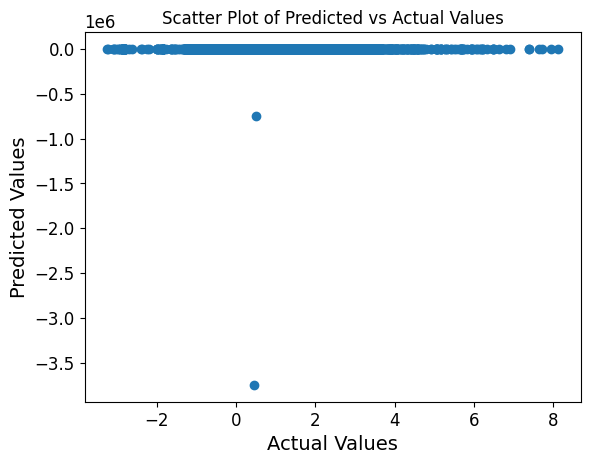

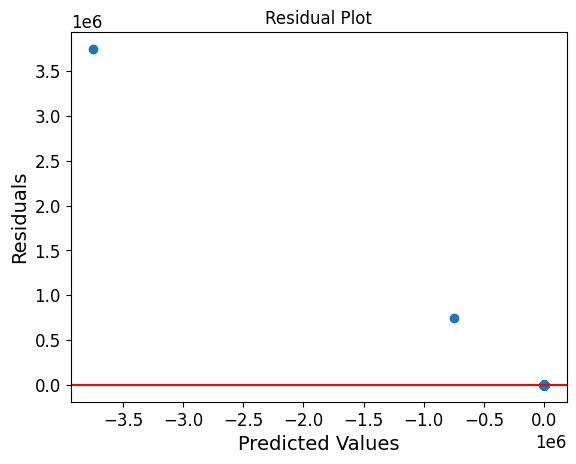

In [6]:
# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Calculate the R-squared (coefficient of determination)
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

# Scatter plot of predicted vs actual values
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Scatter Plot of Predicted vs Actual Values')
plt.show()

# Residual plot
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

#Neural Networks

We also trained the model using a Neural Network with two (2) layers of size ten (10) nodes for the regression. We wanted to see if we could get a better result. Artificial Neural Networks for Regression over Linear can learn the complex non-linear relationship  whereas linear regression can only learn the linear relationship between the features and target. Artificial Neural Networks have the ability to learn the complex relationship between the features and target due to the presence of activation function in each layer. 

The methodology to build the Neural Network used is:

1.Define the neural network structure ( # of input units, # of hidden units, etc).

2.Initialize the model's parameters

Loop:

3.Implement forward propagation

4.Compute loss

5.Implement backward propagation to get the gradients

6.Update parameters (gradient descent)



896/896 [==============================] - 1s 2ms/step - loss: 0.0743
Mean Squared Error: 0.0743151307106018


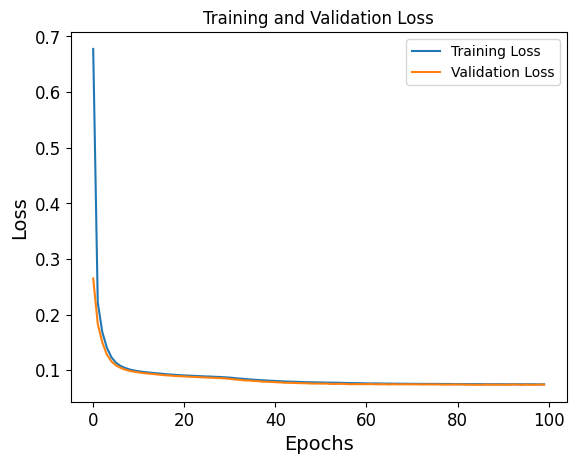

In [7]:
# Neural network regression model
# 2-layer

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras


# Separate the input features (X) and the target variable (y)
X = df.drop('rate_spread', axis=1).values
y = df['rate_spread'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Create a data preprocessing pipeline
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the architecture of the neural network regression model
model = keras.Sequential([
    keras.layers.Dense(10, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(1)  # Output layer with one neuron for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model and store the training history
history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=1000, validation_data=(X_test_scaled, y_test), verbose=0)

# Evaluate the model on the testing set
mse = model.evaluate(X_test_scaled, y_test)
print("Mean Squared Error:", mse)


# Plot the training and validation loss over time
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Three Layer Neural Network

896/896 [==============================] - 2s 2ms/step - loss: 0.0808 - mse: 0.0724
Loss & Mean Squared Error: [0.08079362660646439, 0.07244019210338593]


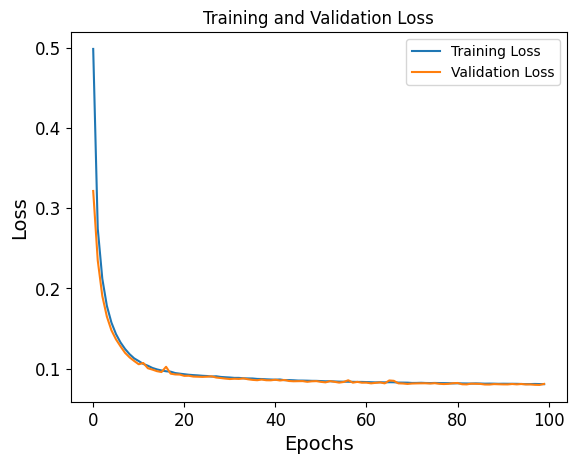

In [8]:
# 3-layer neural network

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers

# Separate the input features (X) and the target variable (y)
X = df.drop('rate_spread', axis=1).values
y = df['rate_spread'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Create a data preprocessing pipeline
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#define a model
model = keras.Sequential([
    keras.layers.Dense(units=10, input_shape=(X_train.shape[1],), activation='relu',kernel_regularizer=regularizers.l2(0.01)),
    keras.layers.Dense(units=10, activation='relu',kernel_regularizer=regularizers.l2(0.01)),
    keras.layers.Dense(units=1)
])

# Compile the model with an optimizer, loss function, and metric
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

# Train the model on your data
history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=512, validation_data=(X_test_scaled, y_test), verbose=0)

# Evaluate the model on your test data
mse = model.evaluate(X_test_scaled, y_test)


print("Loss & Mean Squared Error:", mse)


plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Learning curves are plots of the model’s performance on the training set and the validation set as a function of the training set size (or the training iteration). 

In [9]:
df.columns

Index(['loan_amount', 'loan_to_value_ratio', 'interest_rate', 'rate_spread',
       'loan_term', 'property_value', 'total_units', 'income',
       'debt_to_income_ratio',
       'derived_dwelling_category_Single Family (1-4 Units):Manufactured',
       'derived_dwelling_category_Single Family (1-4 Units):Site-Built',
       'derived_race_Asian', 'derived_race_Black or African American',
       'derived_race_White', 'derived_sex_Female', 'derived_sex_Joint',
       'derived_sex_Male', 'business_or_commercial_purpose_1',
       'business_or_commercial_purpose_2', 'occupancy_type_1',
       'occupancy_type_2', 'occupancy_type_3'],
      dtype='object')

##Regularized Model
A good way to reduce overfitting is to regularize the model (i.e., to constrain it): the fewer degrees of freedom it has, the harder it will be for it to overfit the data.

A simple way to regularize a polynomial model is to reduce the number of polynomial degrees. For a linear model, regularization is typically achieved by constraining the weights of the model. We will use Ridge Regression to implement weight constraint.

##Ridge Regression
Ridge Regression (also called Tikhonov regularization ) is a regularized version of Linear Regression: a regularization term equal to $\frac{1}{2}\sum_{i=1}^n \theta_{i}^2$ i is added to the cost function. This forces the learning algorithm to not only fit the data but also keep the model weights as small as possible. Note that the regularization term should only be added to the cost function during training. Once the model is trained, you want to use the unregularized performance measure to evaluate the model’s performance.

The hyperparameter α controls how much you want to regularize the model. If α = 0, then Ridge Regression is just Linear Regression. If α is very large, then all weights end up very close to zero and the result is a flat line going through the data’s mean.

$$ J(θ) = MSE (θ) + α  \frac{1}{2}\sum_{i=1}^n \theta_{i}^2 $$

Mean Squared Error: 0.09601065422985178
R-squared: 0.8040034880048675


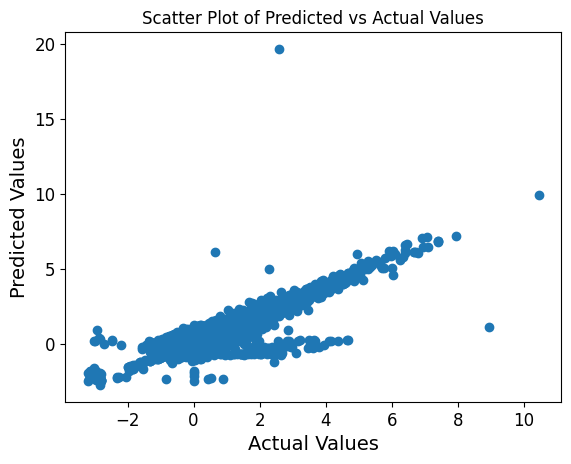

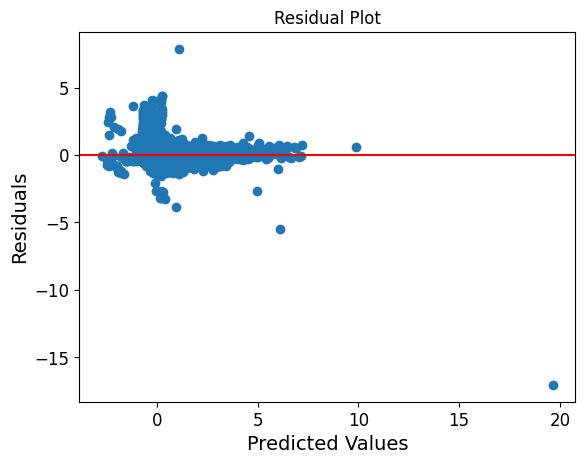

In [10]:
# Linear regression model with Regularization

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

np.random.seed(1)

# Separate the input features (X) and the target variable (y)
X = df.drop('rate_spread', axis=1)
y = df['rate_spread']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Create a scikit-learn pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('polynomial', PolynomialFeatures(degree=2)),
    ('regression', Ridge(alpha=0.1))
])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = pipeline.predict(X_test)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Calculate the R-squared (coefficient of determination)
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

# Scatter plot of predicted vs actual values
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Scatter Plot of Predicted vs Actual Values')
plt.show()

# Residual plot
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

In [11]:
# Linear regression model with Regularization

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer, r2_score

np.random.seed(1)

# Separate the input features (X) and the target variable (y)
X = df.drop('rate_spread', axis=1)
y = df['rate_spread']





#Testing the Model

The train-test split procedure is used to estimate the performance of machine learning algorithms when they are used to make predictions on data not used to train the model.

It is a fast and easy procedure to perform, the results of which allow you to compare the performance of machine learning algorithms for your predictive modeling problem. The train-test split procedure is appropriate when you have a very large dataset, a costly model to train, or require a good estimate of model performance quickly.

It can be used for classification or regression problems and can be used for any supervised learning algorithm.

The procedure involves taking a dataset and dividing it into two subsets. The first subset is used to fit the model and is referred to as the training dataset. The second subset is not used to train the model; instead, the input element of the dataset is provided to the model, then predictions are made and compared to the expected values. This second dataset is referred to as the test dataset.

Train Dataset: Used to fit the machine learning model.
Test Dataset: Used to evaluate the fit machine learning model.
The objective is to estimate the performance of the machine learning model on new data: data not used to train the model.

This is how we expect to use the model in practice. Namely, to fit it on available data with known inputs and outputs, then make predictions on new examples in the future where we do not have the expected output or target values.

We used an 80/20 split instead of something like a k-fold cross-validation procedure because we have sufficient data.

In addition to dataset size, another reason to use the train-test split evaluation procedure is computational efficiency.

Some models are very costly to train, and in that case, repeated evaluation used in other procedures is intractable. An example might be deep neural network models. In this case, the train-test procedure is commonly used.

Alternately, a project may have an efficient model and a vast dataset, although may require an estimate of model performance quickly. Again, the train-test split procedure is approached in this situation.

In [12]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Create a scikit-learn pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('polynomial', PolynomialFeatures(degree=2)),
    ('regression', Ridge(alpha=0.1))
])

model = LinearRegression()
model.get_params().keys()
# Define the parameter grid for the grid search
param_grid = {
    'polynomial__degree': [1,2],
    'regression__alpha': np.logspace(-3, 3, 7)
}


scorer = make_scorer(r2_score)

#search for best model hyperparameters
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring=scorer)
grid_search.fit(X_train, y_train)

print("Best hyperparameters: ", grid_search.best_params_)
print("Best R Square: ", grid_search.best_score_)

Best hyperparameters:  {'polynomial__degree': 2, 'regression__alpha': 1000.0}
Best R Square:  0.8182137108245179


Mean Squared Error: 0.08630384434852473
R-squared: 0.8238190063408363


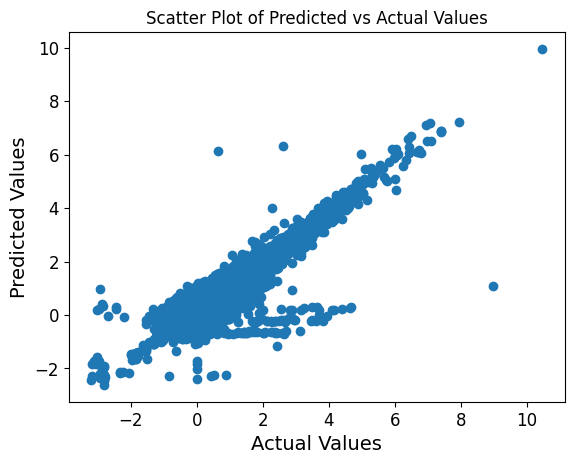

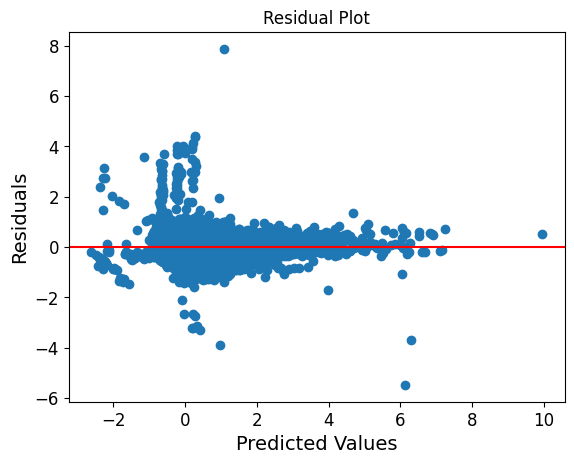

In [13]:
# Linear regression model with the best results from GridSearch in above cell.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

np.random.seed(1)

# Separate the input features (X) and the target variable (y)
X = df.drop('rate_spread', axis=1)
y = df['rate_spread']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Create a scikit-learn pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('polynomial', PolynomialFeatures(degree=grid_search.best_params_['polynomial__degree'])),
    ('regression', Ridge(alpha=grid_search.best_params_['regression__alpha']))
])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = pipeline.predict(X_test)

# Calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

# Calculate the R-squared (coefficient of determination)
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

# Scatter plot of predicted vs actual values
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Scatter Plot of Predicted vs Actual Values')
plt.show()

# Residual plot
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()